## Install Python packages pyikarus and dune-iga

In [80]:
#%pip install pyikarus==0.3.3.dev20230616132637  --no-build-isolation --verbose --upgrade
#%pip install dune-iga --no-build-isolation --verbose --upgrade

### Import packages

In [81]:
import matplotlib
import dune.grid
import dune.functions
import ikarus as iks
import ikarus.finite_elements
import ikarus.utils
import ikarus.assembler
import ikarus.dirichletValues
import numpy as np
import scipy as sp
from dune.vtk import  vtkWriter
from dune.iga import reader as readeriga
from dune.iga.basis import defaultGlobalBasis , Nurbs
from dune.iga import IGAGrid

## Create grid

In [82]:
reader = (readeriga.json, "element_trim.ibra")
gridView = IGAGrid(reader, dimgrid=2, dimworld=2)
gridView.hierarchicalGrid.globalRefine(4)

IbraReader successfully read in 1 patch with 5 edges.

Created serial ALUGrid<2,2,simplex> from input stream. 


Created serial ALUGrid<2,2,simplex> from input stream. 


Created serial ALUGrid<2,2,simplex> from input stream. 


Created serial ALUGrid<2,2,simplex> from input stream. 


Created serial ALUGrid<2,2,simplex> from input stream. 


Created serial ALUGrid<2,2,simplex> from input stream. 


Created serial ALUGrid<2,2,simplex> from input stream. 


Created serial ALUGrid<2,2,simplex> from input stream. 


Created serial ALUGrid<2,2,simplex> from input stream. 


Created serial ALUGrid<2,2,simplex> from input stream. 


Created serial ALUGrid<2,2,simplex> from input stream. 


Created serial ALUGrid<2,2,simplex> from input stream. 


Created serial ALUGrid<2,2,simplex> from input stream. 


Created serial ALUGrid<2,2,simplex> from input stream. 


Created serial ALUGrid<2,2,simplex> from input stream. 


Created serial ALUGrid<2,2,simplex> from input stream. 


Created serial AL

### Alternative grid

In [83]:
#lowerLeft = [-1,-1]
##upperRight = [1,1]
#elements = [3,3]

#gridView = dune.grid.structuredGrid(lowerLeft,upperRight,elements)
#gridView.hierarchicalGrid.globalRefine(0)
#gridView.plot()

In [84]:
%apt-get install -qq xvfb
%pip install pyvista panel -q

import os
os.system('/usr/bin/Xvfb :99 -screen 0 1024x768x24 &')
os.environ['DISPLAY'] = ':99'

import panel as pn
pn.extension('vtk')

UsageError: Line magic function `%apt-get` not found.


### Write grid to file

In [85]:
vtkWriter = gridView.trimmedVtkWriter()
vtkWriter.write(name="TestGrid")


Created serial ALUGrid<2,2,simplex> from input stream. 


Created serial ALUGrid<2,2,simplex> from input stream. 


Created serial ALUGrid<2,2,simplex> from input stream. 


Created serial ALUGrid<2,2,simplex> from input stream. 


Created serial ALUGrid<2,2,simplex> from input stream. 


Created serial ALUGrid<2,2,simplex> from input stream. 


Created serial ALUGrid<2,2,simplex> from input stream. 


Created serial ALUGrid<2,2,simplex> from input stream. 


Created serial ALUGrid<2,2,simplex> from input stream. 


Created serial ALUGrid<2,2,simplex> from input stream. 


Created serial ALUGrid<2,2,simplex> from input stream. 


Created serial ALUGrid<2,2,simplex> from input stream. 


Created serial ALUGrid<2,2,simplex> from input stream. 


Created serial ALUGrid<2,2,simplex> from input stream. 


Created serial ALUGrid<2,2,simplex> from input stream. 


Created serial ALUGrid<2,2,simplex> from input stream. 


Created serial ALUGrid<2,2,simplex> from input stream. 


Created seria

### Draw grid

In [86]:
import pyvista as pv
pv.set_jupyter_backend('client')
mesh = pv.read("TestGrid.vtu")
mesh.plot()

Widget(value="<iframe src='http://localhost:39101/index.html?ui=P_0x7f645a019a80_0&reconnect=auto' style='widt…

### Add Lagrangian basis

In [87]:
from dune.iga.basis import Nurbs
from basishelper import globalBasis
import basishelper
import importlib
importlib.reload(basishelper)
basis = globalBasis(gridView, dune.functions.Power(Nurbs(),2))

print('We have {} dofs.'.format(len(basis.flat())))
print('We have {} vertices.'.format(gridView.size(2)))
print('We have {} elements.'.format(gridView.size(0)))

We have 462 dofs.
We have 231 vertices.
We have 198 elements.


### Init load factor and displacement vector

In [88]:
d = np.zeros(len(basis.flat()))
lambdaLoad = iks.ValueWrapper(.1)

### Create finite element requirements

In [89]:
req = iks.FErequirements()
req.addAffordance(iks.ScalarAffordances.mechanicalPotentialEnergy)
req.addAffordance(iks.VectorAffordances.forces)
req.addAffordance(iks.MatrixAffordances.stiffness)

req.insertParameter(iks.FEParameter.loadfactor,lambdaLoad)
req.insertGlobalSolution(iks.FESolutions.displacement,d)

### Define volume load and boundary loads

In [90]:
def volumeLoad(x,lambdaVal) :
    return np.array([lambdaVal*x[0]*2*0, 2*lambdaVal*x[1]*0])

def neumannLoad(x,lambdaVal) :
    return np.array([lambdaVal*100, lambdaVal])

indexSet = gridView.indexSet
neumannVertices = np.zeros(len(basis.flat()), dtype=bool)
#basis.interpolate(neumannVertices, lambda x :  True  if x[1]==1 else False)
#print(help(gridView))
#print(help(gridView.vertices))
for element in gridView.elements:
    for vertex in element.vertices:
        neumannVertices[indexSet.index(vertex)]= True  if vertex.geometry.center[0]==1 else False
from dune.iga import boundaryPatch
boundaryPatch = boundaryPatch(gridView,neumannVertices)

### Create vector of finite elements

In [91]:
fes = []
for e in gridView.elements:
    fes.append(iks.finite_elements.linearElasticElement(basis,e,1000,0.2,volumeLoad,boundaryPatch,neumannLoad))


### print forces and stiffness of first element

In [92]:
forces = np.zeros(18)
stiffness = np.zeros((18,18))
fes[1].calculateVector(req,forces)
fes[1].calculateMatrix(req,stiffness)
np.set_printoptions(precision=3)
print('Forces:\n {}'.format(forces))
print('Stiffness:\n {}'.format(stiffness))
print('Eigenvalues: ',np.real(sp.linalg.eigvals(stiffness)))

Forces:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Stiffness:
 [[ 486.111  156.25  -277.778  -52.083   34.722   52.083 -243.056 -156.25
     0.       0.       0.       0.       0.       0.       0.       0.
     0.       0.   ]
 [ 156.25   486.111   52.083   34.722  -52.083 -277.778 -156.25  -243.056
     0.       0.       0.       0.       0.       0.       0.       0.
     0.       0.   ]
 [-277.778   52.083  486.111 -156.25  -243.056  156.25    34.722  -52.083
     0.       0.       0.       0.       0.       0.       0.       0.
     0.       0.   ]
 [ -52.083   34.722 -156.25   486.111  156.25  -243.056   52.083 -277.778
     0.       0.       0.       0.       0.       0.       0.       0.
     0.       0.   ]
 [  34.722  -52.083 -243.056  156.25   486.111 -156.25  -277.778   52.083
     0.       0.       0.       0.       0.       0.       0.       0.
     0.       0.   ]
 [  52.083 -277.778  156.25  -243.056 -156.25   486.111  -52.083   34.722
     0.       0.    

### Create Dirichlet boundary conditions

In [93]:
dirichletValues = iks.dirichletValues(basis.flat()) 

def fixTopEdge(vec,localIndex,localView,intersection):
    if (intersection.geometry.center[1]> 1- 1e-8):
        vec[localView.index(localIndex)]= True

dirichletValues.fixBoundaryDOFsUsingLocalViewAndIntersection(fixTopEdge)

### Create assembler

In [94]:
#assembler = sparseFlatAssembler(fes,dirichletValues)
assemblerSparse = iks.assembler.sparseFlatAssembler(fes,dirichletValues)

Msparse = assemblerSparse.getMatrix(req)
forces = assemblerSparse.getVector(req)
#print(Msparse)
#print(forces)

### Solve for displacements and write to paraview

In [95]:
d = sp.sparse.linalg.spsolve(Msparse,-forces)
dispFunc = basis.flat().asFunction(d)
externalForcesFunc= basis.flat().asFunction(forces)



In [96]:
vtkWriter= gridView.trimmedVtkWriter()
vtkWriter.addPointData(dispFunc,"displacements")
vtkWriter.addPointData(externalForcesFunc,"externalForces")
vtkWriter.write(name="TestGridwithData")

### Plot here using matplot lib

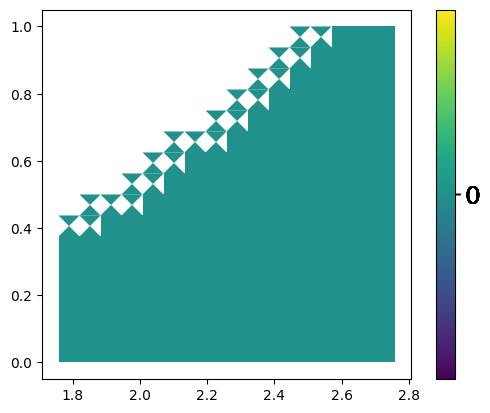

In [ ]:
import dune.plotting
dune.plotting.plot(solution=dispFunc,gridLines=None)